In [1]:
#get larlite
from larlite import larlite as ll
from larlite import larutil as lu

geo=lu.Geometry.GetME()
geoH=lu.GeometryHelper.GetME()

import ROOT

In [2]:
#graphics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import root_numpy as rn
import pandas as pd
%matplotlib inline

/Library/Python/2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.8.0rc1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [3]:
#create storage manager
sm = ll.storage_manager()
sm.set_io_mode(ll.storage_manager.kREAD)
FILENAME="mcc8_post_pi0cut.root"
sm.add_in_filename(FILENAME)
sm.open()

True

In [4]:
tree = rn.root2array('quality_ana.root')
df_tree = pd.DataFrame(tree)

STARTING! 
~~~~~~~~~~~> event is 215 <~~~~~~~~~~~
SHAPE  (115, 5)
pt1!!  [ 1296.43833203  3603.        ]
pt2!!  [ 1235.95274839  5368.        ]


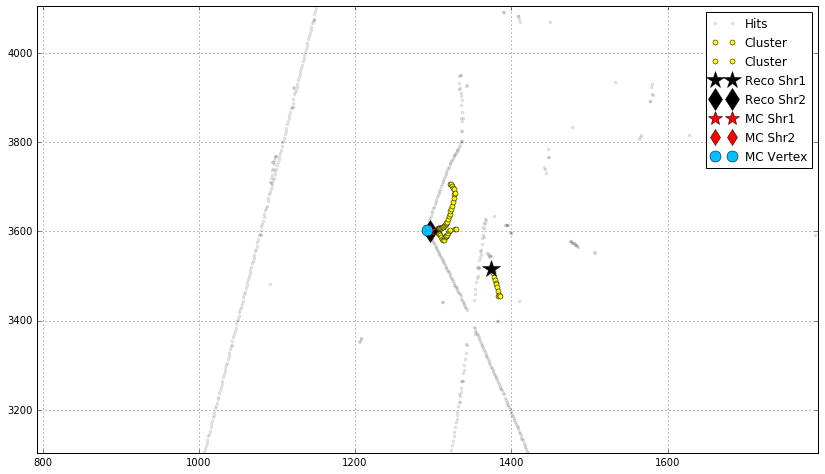

pt1!!  [ 1238.32689  3603.     ]
pt2!!  [ 1320.23852987  5368.        ]


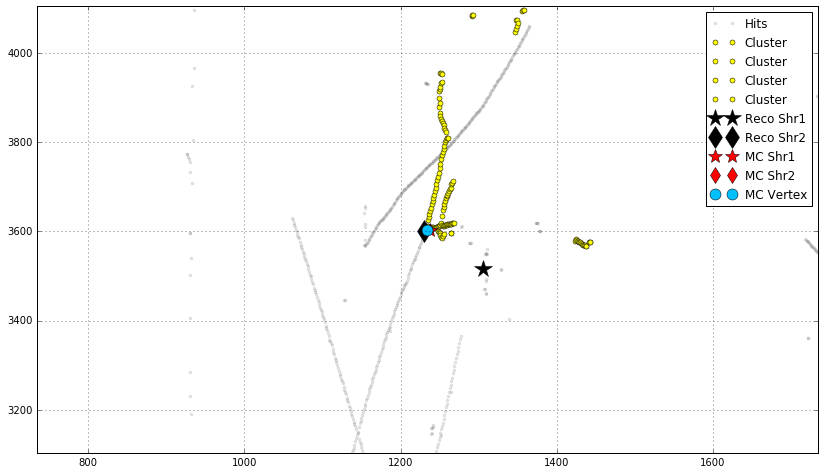

pt1!!  [ 1862.76522203  3603.        ]
pt2!!  [ 1884.19127826  5368.        ]


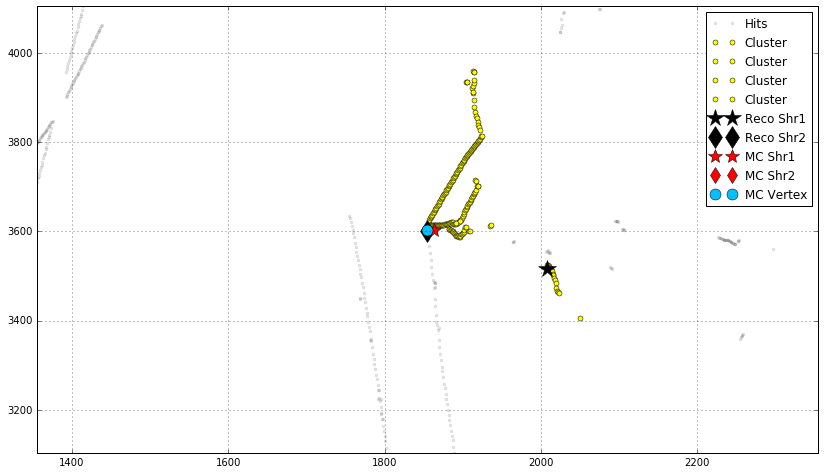

In [43]:
print "STARTING! "
#for evt in xrange(1050):
while True:
    evt = 215
    print "~~~~~~~~~~~> event is %d <~~~~~~~~~~~"%evt
    
    sm.go_to(evt) 
    df_query = df_tree.query('event == %i' % (int(evt)+1))
    #print "QUERY INOF " , df_query.head()
    
    #get hits and clusters
    event_hits     = sm.get_data(ll.data.kHit,"gaushit")
    event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")
    event_mcshowers = sm.get_data(ll.data.kMCShower,"mcreco")
 
    #get ass
    event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")
    cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())
    
    mcshowerdata = rn.root2array(FILENAME,
                            treename='mcshower_mcreco_tree',
                            branches=['mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.X()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Y()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Z()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fDetProfile._position.Energy()',
                                      'mcshower_mcreco_branch.vector<larlite::mcshower>.fMotherPDGCode'])
                                      
    mcs_df= pd.DataFrame({'X'   : mcshowerdata[evt][0],
                          'Y'   : mcshowerdata[evt][1],
                          'Z'   : mcshowerdata[evt][2],
                          'E'   : mcshowerdata[evt][3],
                          'MPDG' : mcshowerdata[evt][4]})

    mcs_df_pi0 = mcs_df.query('E > 0')# and X > 20 and X < 236.35 and Y > -96.5 and Y < 96.5 \
                         #    and Z > 10 and Z < 1026.7')# and MPDG == 111')

    print "SHAPE ", mcs_df_pi0.shape
    
    vtx=ROOT.std.vector('double')()
    vtx.resize(3)
    vtx[0]=df_query.mc_vtx_x.values[0]
    vtx[1]=df_query.mc_vtx_y.values[0]
    vtx[2]=df_query.mc_vtx_z.values[0]

    gausdata = rn.root2array(FILENAME,
                            treename='hit_gaushit_tree',
                            branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

    hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                           'PeakTime'  : gausdata[evt][0],
                           'Plane'     : gausdata[evt][2]})

    
    for plane in [0,1,2]:

        fig,ax=plt.subplots(figsize=(14,8)) #0*2,6*2))

        phits = hits_df.query("Plane=={}".format(plane))

        ax.plot(phits.Wire,phits.PeakTime,'o',color='black',markersize=3,alpha=0.1,label='Hits')
    
        
        # plot each cluster and userinfo
        for ix,cluster in enumerate(cluster_to_hit_ass):

            ##############################
            #get the hits for this clusters
            slice_=np.array(cluster)
            if event_clusters[ix].Plane().Plane != plane: continue
            if slice_.size == 0: continue

            hslice = hits_df.iloc[slice_]
            ax.plot(hslice.Wire,hslice.PeakTime,'o',color='yellow',markersize=5,label='Cluster')
    
#         for i in xrange(mcs_df_pi0.shape[0]):
#             shr=ROOT.std.vector('double')()
#             shr.resize(3)
#             shr[0]=mcs_df_pi0.X.values[i]
#             shr[1]=mcs_df_pi0.Y.values[i]
#             shr[2]=mcs_df_pi0.Z.values[i]
#             px = geoH.Point_3Dto2D(shr.data(),plane)
#             pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
#             ax.plot(pt[0],pt[1],'*',markersize=16,color='green')
    
    
        #for i in xrange(df_query.shape[0]):
        shr=ROOT.std.vector('double')()
        shr.resize(3)
        shr[0]=df_query.reco_shr1_st_x.values[0]
        shr[1]=df_query.reco_shr1_st_y.values[0]
        shr[2]=df_query.reco_shr1_st_z.values[0]
        px = geoH.Point_3Dto2D(shr.data(),plane)
            
        pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
        ax.plot(pt[0],pt[1],'*',markersize=18,color='k',label='Reco Shr1')

        shr=ROOT.std.vector('double')()
        shr.resize(3)
        shr[0]=df_query.reco_shr2_st_x.values[0]
        shr[1]=df_query.reco_shr2_st_y.values[0]
        shr[2]=df_query.reco_shr2_st_z.values[0]
        px = geoH.Point_3Dto2D(shr.data(),plane)
            
        pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
        ax.plot(pt[0],pt[1],'d',markersize=16,color='k',label='Reco Shr2')
    
        shr=ROOT.std.vector('double')()
        shr.resize(3)
        shr[0]=df_query.mc_shr1_st_x.values[0]
        shr[1]=df_query.mc_shr1_st_y.values[0]
        shr[2]=df_query.mc_shr1_st_z.values[0]
        px = geoH.Point_3Dto2D(shr.data(),plane)
            
        pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
        print "pt1!! ", pt
        ax.plot(pt[0],pt[1],'*',markersize=14,lw=4,color='red',label='MC Shr1')
    
        shr=ROOT.std.vector('double')()
        shr.resize(3)
        shr[0]=df_query.mc_shr2_st_x.values[0]
        shr[1]=df_query.mc_shr2_st_y.values[0]
        shr[2]=df_query.mc_shr2_st_z.values[0]
        px = geoH.Point_3Dto2D(shr.data(),plane)
            
        pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
        print "pt2!! ", pt
        ax.plot(pt[0],pt[1],'d',markersize=12,color='red',label='MC Shr2')
       
        #put vertex information on screen as a big star 
        px = geoH.Point_3Dto2D(vtx.data(),plane)
        pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])

        ax.plot(pt[0],pt[1],'o',markersize=11,color='deepskyblue',label='MC Vertex')

    
        w = 500
        if (pt[0] - w < 0):
            ax.set_xlim(0,pt[0]+w)
        else:
            ax.set_xlim(pt[0]-w,pt[0]+w)
        if (pt[1] -w < 0):
            ax.set_ylim(0,pt[1]+w)
        else:
            ax.set_ylim(pt[1]-w,pt[1]+w)

        plt.legend()
          
        plt.grid()
        plt.show()
    break

In [32]:
#print df_tree

In [ ]:
GOOD EXAMPLE, Evt0